Test of conformal prediction intervals for the daily amount of waste.
Problem: Prediction intervals don't have the designed coverage... I thought CP PIs always guarantee that

In [23]:
import pandas as pd
import numpy as np

from data_preparation import DataProcessor

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


from darts import TimeSeries
from conformal_tights import DartsForecaster, ConformalCoherentQuantileRegressor

In [24]:
waste_data = pd.read_csv("synthetic_waste_data.csv")
fetcher = DataProcessor(waste_data)

In [25]:
agg_waste_df = fetcher.agg_quantity()
agg_waste_df = pd.DataFrame(agg_waste_df)

agg_waste_df

,date,is_weekend,is_holiday,is_Fall,is_Spring,is_Summer,is_Winter,quantity_tons
0,2022-01-01,1.0,1.0,0.0,0.0,0.0,1.0,153.851503
1,2022-01-02,1.0,0.0,0.0,0.0,0.0,1.0,245.846278
2,2022-01-03,0.0,0.0,0.0,0.0,0.0,1.0,574.139774
3,2022-01-04,0.0,0.0,0.0,0.0,0.0,1.0,446.454597
4,2022-01-05,0.0,0.0,0.0,0.0,0.0,1.0,141.906455
...,...,...,...,...,...,...,...,...
1091,2024-12-27,0.0,1.0,0.0,0.0,0.0,1.0,865.147110
1092,2024-12-28,1.0,1.0,0.0,0.0,0.0,1.0,252.648480
1093,2024-12-29,1.0,0.0,0.0,0.0,0.0,1.0,72.427480
1094,2024-12-30,0.0,0.0,0.0,0.0,0.0,1.0,307.403118


In [26]:
data_RM = fetcher.agg_quantity("RegionalWaste Management", by_company= True)
data_lagged_RM = fetcher.create_xgboost_features(data_RM, lags=[6,7,13,14,20,21], lagged_features= False, lagged_ratios= True, trend_indicators=False)


In [27]:
split_index = int(len(data_lagged_RM) * 0.975) 

X = data_lagged_RM.drop(columns=['quantity_tons'])
y = data_lagged_RM['quantity_tons']

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
conformal_predictor = ConformalCoherentQuantileRegressor(estimator=model)

conformal_predictor.fit(X_train, y_train)

y_pred = conformal_predictor.predict(X_test)

y_pred_test_quantiles = conformal_predictor.predict_quantiles(
    X_test, quantiles=(0.025, 0.05, 0.1, 0.5, 0.9, 0.95, 0.975)
    )

In [28]:
print(len(X_test))

24


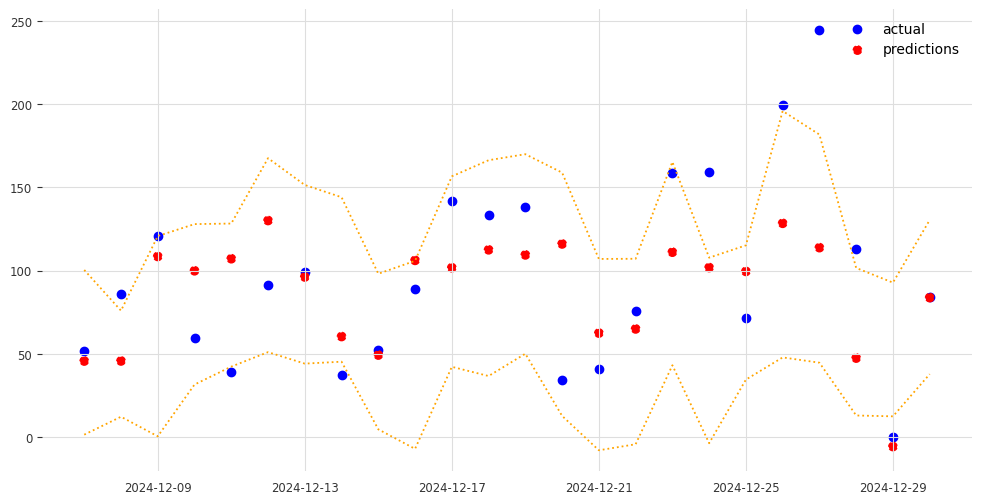

In [29]:
start = 0 
end   = 200

plt.figure(figsize= (12,6))

plt.scatter(y = y_test[start:end], x = X_test.index[start:end], label = "actual", color = "blue")
plt.scatter(y = y_pred[start:end], x = X_test.index[start:end], color = "red", label = "predictions", linestyle = "--")


plt.plot(y_pred_test_quantiles[0.05][start:end], color = "orange", linestyle = ":")
plt.plot(y_pred_test_quantiles[0.95][start:end], color = "orange", linestyle = ":")
#plt.fill_between(y_pred_test_quantiles[0.050], y_pred_test_quantiles[0.9], alpha=0.2, color='orange', label='90% Prediction Interval')

plt.legend()
plt.show()

In [30]:
company_models_lagged_ratios = {}
company_predictions_lagged_ratios = {}

split_index = int(len(company_dfs_lagged_ratios["CommercialServices Inc"]) *0.8) 

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': np.arange(70, 200, 10),
#    'learning_rate': np.arange(0.03, 0.15, 0.02),
#    'max_depth': [3, 4, 5, 6],
#    'colsample_bytree': [0.8, 1.0],
#    'gamma': [0, 0.1, 0.3],
#    'min_child_weight': [1, 3, 5],
#    'reg_alpha': [0, 0.1, 0.5],
#    #'reg_lambda': [0, 0.1, 0.5, 1],
#    #'max_leaves': [0, 10, 20, 50]
}

tscv = TimeSeriesSplit(n_splits=2)  


for company, df in company_dfs_lagged_ratios.items():


    X = df.drop(columns=['quantity_tons'])
    y = df['quantity_tons']

    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)



    conformal_predictor = ConformalCoherentQuantileRegressor(estimator=model)
    conformal_predictor.fit(X_train, y_train)

    y_pred = conformal_predictor.predict(X_test)

    ŷ_test_quantiles = conformal_predictor.predict_quantiles(
    X_test, quantiles=(0.025, 0.05, 0.1, 0.5, 0.9, 0.95, 0.975)
    )
    company_predictions_lagged_ratios[company] = y_pred



KeyError: 'CommercialServices Inc'

In [ ]:
total_predicted_lagged_ratios = np.sum(list(company_predictions_lagged_ratios.values()), axis=0)

total_actual = np.sum(
    [company_dfs_lagged_ratios[company]['quantity_tons'].values[split_index:] for company in company_dfs],
    axis=0
)
rmse_lagged_ratios = np.sqrt(mean_squared_error(total_actual, total_predicted_lagged_ratios))

print(f'XGBoost RMSE with lagged ratios: {rmse_lagged_ratios:.2f}')